# kNN (k-Nearest Neighbors) 

Authors: 
- Fábio D. Pacheco, up202502538

Date: 24/11/2025

### Description

This notebook is used for the following purposes:

In [123]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support 
from sklearn.metrics         import confusion_matrix, classification_report, log_loss
from sklearn.preprocessing   import LabelEncoder
from sklearn.calibration     import calibration_curve

### Load the input data and output class

\begin{equation}
  \mathrm{X} = 
  \begin{bmatrix}
      x^{(1)}_1 & \cdots & x^{(d)}_1 \\
      \vdots & \ddots & \vdots \\
      x^{(1)}_N & \cdots & x^{(d)}_N 
  \end{bmatrix}
  \in \Re^{N \times d},

  \quad
  \vec{y} =
  \begin{bmatrix}
    y_1    \\
    \vdots \\
    y_N    \\
  \end{bmatrix}
  \in \Re^{N}
\end{equation}

where $N$ is the number of samples for a given class $y=C_i$ and $d$ the number of bins of the spectrum.

In [102]:
dataset_dir_path = "../dataset/"

xtrain_path = dataset_dir_path + "xtrain.csv"
xtest_path  = dataset_dir_path + "xtest.csv"

ytrain_path = dataset_dir_path + "ytrain.csv"
ytest_path  = dataset_dir_path + "ytest.csv"

if( os.path.exists(xtrain_path) ):
  X_train = pd.read_csv( xtrain_path, index_col=0 )
if( os.path.exists(ytrain_path) ):
  y_train = pd.read_csv( ytrain_path, index_col=0 )

if( os.path.exists(xtest_path) ):
  X_test = pd.read_csv( xtest_path, index_col=0 )
if( os.path.exists(ytest_path) ):
  y_test = pd.read_csv( ytest_path, index_col=0 )

print(f"Shape of X:{X_train.shape}, y:{y_train.shape}")

le = LabelEncoder()
y_enc = le.fit_transform( y_train["polymer"] )
y_enc_test = le.fit_transform( y_test["polymer"] )

Shape of X:(839, 2151), y:(839, 1)


### Preprocessing functions

#### Apply the Principal Component Analysis (PCA):
An unsupervised learning algorithm that transforms a high-dimensional dataset into a lower-dimensional space while preserving as much variance as possible. The orthogonal space is given by:

\begin{equation}
  \mathrm{Z} = \mathrm{X} \cdot \mathrm{W}
\end{equation}

such that the columns of ($\mathrm{W}$) are principal components where each component maximizes variance, while each component being mutually orthogonal. The covariance is computed as decomposed in its eigenvalues. The the optimization function focus on finding those eigenvalues which correspond to the highest variances that capture a portion of the total variance.

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply the PCA, for a variance of 99%
pca = PCA(
  n_components=0.99,
  svd_solver='full'
)
X_pca = pca.fit_transform( X_scaled ) 

# Transformation reports
print("Original shape:", X_scaled.shape)
print("PCA shape:", X_pca.shape)

Original shape: (839, 2151)
PCA shape: (839, 9)


The variance explained by the $i$-th principal component is given by

\begin{equation*}
  \text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}
\end{equation*}

where $\lambda_i$ is the eigenvalue corresponding to the $i$-th component and $d$ is the total number of features. The cumulative explained variance, computed as

\begin{equation*}
\text{Cumulative Variance}(k) = \sum_{i=1}^{k} \text{Explained Variance Ratio}_i
\end{equation*}

represents the fraction of total variance preserved when keeping the first $k$ components. The cumulative variance allows us to determine the number of components required to retain most of the information while reducing dimensionality. A small number of components typically captures the majority of the variance due to strong correlation among wavelengths, whereas later components mostly encode noise. Choosing fewer components reduces computational cost and the risk of overfitting, but may lose subtle spectral information; retaining more components preserves information at the cost of higher dimensionality and potential noise amplification. In hyperspectral analysis, keeping components that preserve 99\% of variance is common, ensuring minimal loss of important spectral features.


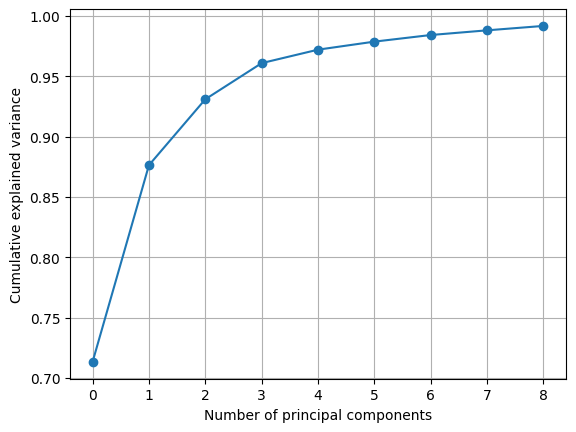

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show( )

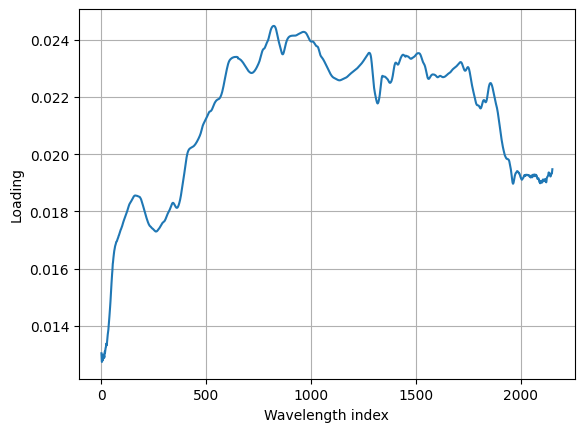

In [22]:
plt.plot(pca.components_[0])
plt.xlabel("Wavelength index")
plt.ylabel("Loading")
plt.grid(True)
plt.show()

The k-Nearest Neighbors (kNN) algorithm is a non-parametric classifier. Given a new sample, kNN identifies the $k$ closest samples in the training set according to a distance metric (in this case Euclidean distance) and assigns the class label most frequent among these neighbors. Formally, for a query sample $\vec{x}_q$, the predicted label $\hat{y}_q$ is

\begin{equation*}
\hat{y}_q = \text{mode}\{ y_i \mid \mathbf{x}_i \in \mathcal{N}_k(\mathbf{x}_q) \}
\end{equation*}

where $\mathcal{N}_k(\mathbf{x}_q)$ denotes the set of $k$ nearest neighbors of $\mathbf{x}_q$ in the training set.  

The choice of $k$ trades off bias and variance: small $k$ can capture fine structure but may overfit, whereas large $k$ produces smoother decision boundaries but may underfit. Distance metrics and feature scaling are crucial, as kNN is sensitive to feature magnitudes. This method is particularly suitable for hyperspectral data when combined with dimensionality reduction techniques like PCA to reduce noise and redundancy.


In [40]:
k = 5 
knn_clf = KNeighborsClassifier(
  n_neighbors=k, 
  metric='euclidean'
)

pipeline = Pipeline([
  ('scaler', StandardScaler()),  # Normalize features
  ('pca', pca),
  ('knn', knn_clf)
])

K-fold cross-validation divides the dataset into $K$ approximately equal subsets, or folds. The model is trained $K$ times, each time using $K-1$ folds for training and the remaining fold for validation. The final performance metric is obtained by averaging the metrics across folds, providing a robust estimate of generalization performance. This is particularly useful when the dataset is small, ensuring that each sample contributes both to training and validation.

In [42]:
K = 4  # Number of folds
skf = StratifiedKFold(
  n_splits=K, 
  shuffle=True, 
  random_state=42
)

# Perform cross-validation
scores = cross_val_score(
  pipeline, 
  X_train.values, 
  y_train.values.ravel(), 
  cv=skf, 
  scoring='accuracy'
)

print(f"Cross-validation accuracy for each fold: {scores}")
print(f"Mean accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation accuracy for each fold: [0.75714286 0.82380952 0.78095238 0.79425837]
Mean accuracy: 0.7890 ± 0.0241


#### Class definition for the actual model assessment

In [128]:
class kNN:
  def __init__(
      self, 
      n_neighbors=3, 
      n_folds=5, 
      n_components=None, 
      metric='euclidean',
      weights='uniform', 
      minkowski_p=2,
      random_state=0 
    ):
    self.k = n_neighbors
    self.K = n_folds
    self.n_components = n_components
    self.metric = metric
    self.weights = weights
    self.minkowski_p = minkowski_p
    self.random_state = random_state

    self.pipeline = None
    self.scores_ = None
    self.results = [ ]

  def build_pipeline(self):
    steps = [ ]
    steps.append(
      ('scaler', StandardScaler( ) )
    ) 
    if self.n_components is not None:
      steps.append(
        ('pca', 
          PCA(
            n_components=self.n_components, 
            svd_solver='full'
          )
        )
      )

    steps.append(
      ('knn', 
        KNeighborsClassifier( 
          n_neighbors=self.k,
          metric=self.metric,
          weights=self.weights,
          p=self.minkowski_p
        )
      )
    )
    self.pipeline = Pipeline(steps)

  def fit(self, X, y, full=False):
    self.build_pipeline( )
    skf = StratifiedKFold(
      n_splits=self.K, 
      shuffle=True, 
      random_state=self.random_state
    )

    self.scores_ = cross_val_score(
      self.pipeline, 
      X, 
      y, 
      cv=skf, 
      scoring='accuracy'
    )

    if( full ):  
      self.pipeline.fit(X, y)

    return self

  def search(self, X, y, k_list, p_list, weights_list, metric_list, pca_list):
    total_configs = (
      len(k_list)
      * len(p_list)
      * len(weights_list)
      * len(metric_list)
      * len(pca_list)
    )

    with tqdm(total=total_configs, desc="kNN hyperparameter search") as pbar:
      for k, p, w, m, n_comp in it.product(
        k_list, p_list, weights_list, metric_list, pca_list
      ):
        self.k = k
        self.weights = w
        self.metric = m
        self.minkowski_p = p
        self.n_components = n_comp

        self.fit(X, y)

        self.results.append({
          "k": k,
          "metric": m,
          "weights": w,
          "p": p,
          "pca": n_comp,
          "mean_accuracy": self.scores_.mean(),
          "std_accuracy": self.scores_.std()
        })

        pbar.update(1)

    return self.results

  def predict(self, X):
    if self.pipeline is None:
      raise RuntimeError("Model has not been fitted yet.")
    return self.pipeline.predict(X)

  def predict_proba(self, X):
    if self.pipeline is None:
      raise RuntimeError("Model has not been fitted yet.")
    return self.pipeline.predict_proba(X)

  def summary(self):
    if self.scores_ is None:
      print("Fit the model first.")
      return

    print(f"k={self.k} with metric={self.metric}({self.minkowski_p}) and weights={self.weights} and PCA={self.n_components}" )
    print(f"Cross-validation accuracy per fold: {self.scores_}")
    print(f"Mean accuracy: {self.scores_.mean():.4f} ± {self.scores_.std():.4f}")

#### Test setup

The hyperparameters explored in this setup are the number of neighbors $k \in \{3,5,7,9\}$, the distance metric (Euclidean, Manhattan, and Cosine), the distance weighting scheme (uniform and distance-based), and the Minkowski distance order fixed to $p=2$. Dimensionality reduction is optionally applied using PCA, either disabled or configured to retain $95\%$ or $99\%$ of the cumulative explained variance. Model evaluation is performed using stratified $K$-fold cross-validation with a fixed number of folds $K=8$.

The distance metric used is determining similarity between spectral samples. Euclidean distance is included as a baseline metric performs well when features are properly normalized. Manhattan distance is evaluated due to its increased robustness to localized variations and noise, which can be relevant in spectral data affected by measurement artifacts. Cosine distance is also considered, as it measures angular similarity between spectra and is therefore less sensitive to absolute magnitude differences, making it suitable for cases where relative spectral shape is more informative than overall intensity. 

The weighting mechanism applied determines how each neighbor contributes to the final decision. Uniform weighting assigns equal importance to all neighbors within the neighborhood, providing a simple and stable baseline. Distance-based weighting assigns higher influence to closer neighbors, which can improve classification performance when local spectral similarity is more informative than global structure, particularly in heterogeneous datasets or when class boundaries are not well separated.

In [ ]:
model = kNN( n_folds=8 )

results = model.search(
  X_train.values, y_enc,
  k_list=[3, 5, 7, 9],
  p_list=[2],
  metric_list=['euclidean', 'manhattan', 'cosine'], 
  weights_list=['uniform', 'distance'],
  pca_list=[None, 0.95, 0.99, 0.999]
)

kNN hyperparameter search: 100%|██████████| 72/72 [14:22<00:00, 11.98s/it]


#### Export scores

In [ ]:
scores_path = os.path.join( dataset_dir_path, "knn_results.csv" )

df_results = pd.DataFrame( results )
df_results.sort_values( "mean_accuracy", ascending=False ).head( )
df_results.to_csv( scores_path, index=False )

print(f"Scores saved at {scores_path}")

Scores saved at ../dataset/knn_results.csv


In [120]:
print(pd.DataFrame(results))

    k     metric   weights  p   pca  mean_accuracy  std_accuracy
0   3  euclidean   uniform  2   NaN       0.837843      0.033018
1   3  euclidean   uniform  2  0.95       0.760382      0.044811
2   3  euclidean   uniform  2  0.99       0.852152      0.033293
3   3  manhattan   uniform  2   NaN       0.870055      0.030607
4   3  manhattan   uniform  2  0.95       0.752026      0.055844
.. ..        ...       ... ..   ...            ...           ...
67  9  manhattan  distance  2  0.95       0.771085      0.048508
68  9  manhattan  distance  2  0.99       0.879544      0.034705
69  9     cosine  distance  2   NaN       0.856983      0.034297
70  9     cosine  distance  2  0.95       0.752038      0.045969
71  9     cosine  distance  2  0.99       0.872447      0.019738

[72 rows x 7 columns]


#### Best score model

In [129]:
best_mean = pd.DataFrame([ max( results, key=lambda r: r["mean_accuracy"] ) ])
best_std  = pd.DataFrame([ min( results, key=lambda r: r["std_accuracy"] ) ])

best_mean_row = best_mean.iloc[0]
model_bm = kNN( 
  n_neighbors=int(best_mean_row['k']),
  n_folds=8,
  n_components=None if pd.isna(best_mean_row['pca']) else float(best_mean_row['pca']),
  metric=best_mean_row['metric'],
  weights=best_mean_row['weights'],
  minkowski_p=int(best_mean_row['p']),
  random_state=0
)

best_std_row = best_std.iloc[0]
model_bs = kNN( 
  n_neighbors=int(best_std_row['k']),
  n_folds=8,
  n_components=None if pd.isna(best_std_row['pca']) else float(best_std_row['pca']),
  metric=best_std_row['metric'],
  weights=best_std_row['weights'],
  minkowski_p=int(best_std_row['p']),
  random_state=0
)

model_bm.fit(X_train.values, y_enc, True )
model_bs.fit(X_train.values, y_enc, True )

print( best_mean )
print( best_std )

   k     metric   weights  p   pca  mean_accuracy  std_accuracy
0  3  manhattan  distance  2  0.99       0.886745       0.02462
   k  metric   weights  p   pca  mean_accuracy  std_accuracy
0  5  cosine  distance  2  0.99       0.878423      0.014898


#### Test the model with the test dataset

In [140]:
class kNN_Metric:
  def __init__(
    self,
    model, 
    X_test, 
    y_test
  ):
    self.model = model
    self.X_test = X_test
    self.y_test = y_test.ravel()

    self.y_pred = None
    self.y_proba = None

  def predict( self ):
    self.y_pred = self.model.predict(self.X_test)
    self.y_proba = self.model.predict_proba(self.X_test)

  def classification_metrics(self):
    return {
      "accuracy": accuracy_score( self.y_test, self.y_pred ),
      "balanced_accuracy": balanced_accuracy_score( self.y_test, self.y_pred )
    }

  def classwise_metrics(self):
    precision, recall, f1, support = precision_recall_fscore_support(
      self.y_test,
      self.y_pred,
      average=None
    )

    return {
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "support": support,
      "confusion_matrix": confusion_matrix( self.y_test, self.y_pred ),
      "classification_report": classification_report( self.y_test, self.y_pred )
    }

  def probabilistic_metrics(self):
    return {
      "log_loss": log_loss(self.y_test, self.y_proba),
      "brier_score": self._multiclass_brier_score( self.y_test, self.y_proba  )
    }

  def _multiclass_brier_score(self, y_true, y_proba):
    n_classes = y_proba.shape[1]
    y_true_oh = np.eye(n_classes)[y_true]
    return np.mean(
      np.sum( 
        (y_proba - y_true_oh) ** 2, 
        axis=1
      )
    )

  def expected_calibration_error(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
      mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
      if np.any(mask):
        acc = correct[mask].mean()
        conf = confidences[mask].mean()
        ece += np.abs(acc - conf) * np.sum(mask) / len(confidences)

    return ece

  def plot_reliability_diagram(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    frac_pos, mean_conf = calibration_curve(
      correct, confidences, n_bins=n_bins
    )

    plt.figure(figsize=(5, 5))
    plt.plot(mean_conf, frac_pos, "o-", label="kNN")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
    plt.xlabel("Mean confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("Reliability Diagram")
    plt.grid(True)
    plt.legend()
    plt.show()

  def plot_confusion_matrix(self, normalize=True, cmap="Blues"):
    cm = self.classwise_metrics( )["confusion_matrix"]

    if normalize:
      cm = cm / cm.sum(axis=1, keepdims=True)
      title = "Normalized Confusion Matrix"
    else:
      title = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax)

    n_classes = cm.shape[0]
    ticks = np.arange(n_classes)

    ax.set(
      xticks=ticks,
      yticks=ticks,
      xlabel="Predicted label",
      ylabel="True label",
      title=title
    )

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i in range(n_classes):
      for j in range(n_classes):
        ax.text(
          j, i, format(cm[i, j], fmt),
          ha="center", va="center",
          color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.show()

  def evaluate(self):
    self.predict( )

    results = {
      "classification": self.classification_metrics(),
      "classwise": self.classwise_metrics(),
      "probabilistic": self.probabilistic_metrics(),
      "ece": self.expected_calibration_error(),
    }

    return results

==== Max mean model
Classification:    accuracy  balanced_accuracy
0  0.904762           0.901263
Probabilistic:    log_loss  brier_score
0  1.818314     0.145823
ECE: 0.04446913926667341
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        46
           1       0.87      0.91      0.89        75
           2       0.96      0.89      0.92        53
           3       0.83      0.83      0.83        36

    accuracy                           0.90       210
   macro avg       0.91      0.90      0.90       210
weighted avg       0.91      0.90      0.90       210



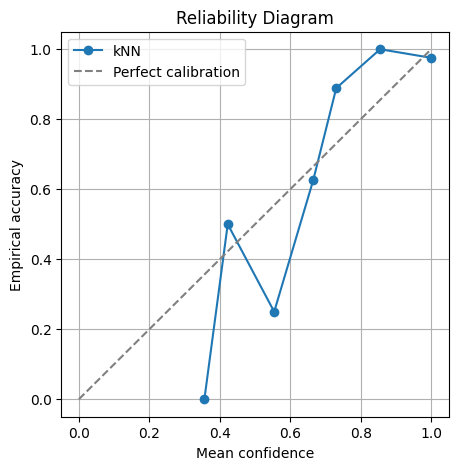

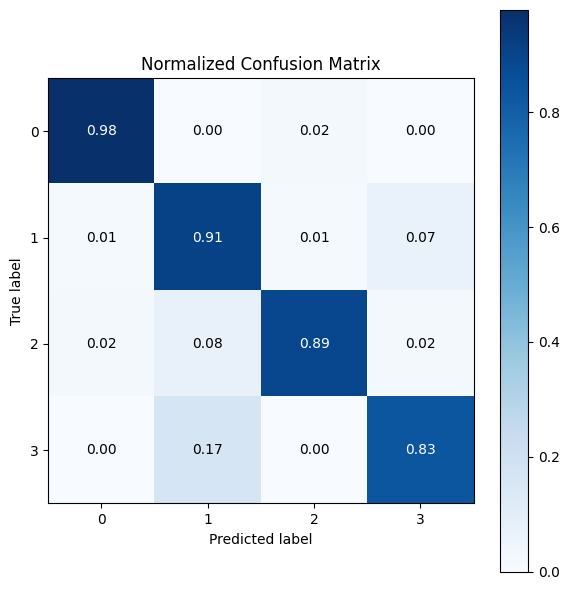

==== Min variance model
Classification: {'accuracy': 0.919047619047619, 'balanced_accuracy': 0.9177677513444537}
Probabilistic: {'log_loss': 0.8461598849797378, 'brier_score': np.float64(0.13023895038794325)}
ECE: 0.034101046070070674
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.91      0.92      0.91        75
           2       0.96      0.91      0.93        53
           3       0.82      0.89      0.85        36

    accuracy                           0.92       210
   macro avg       0.92      0.92      0.92       210
weighted avg       0.92      0.92      0.92       210



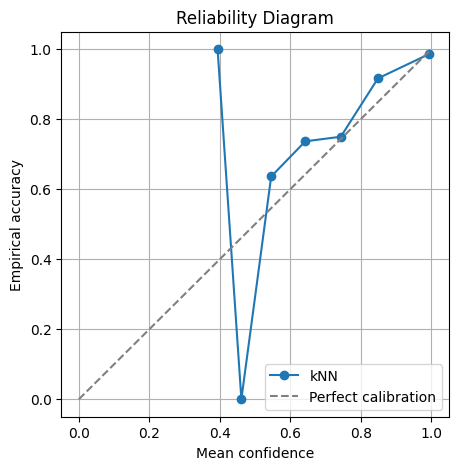

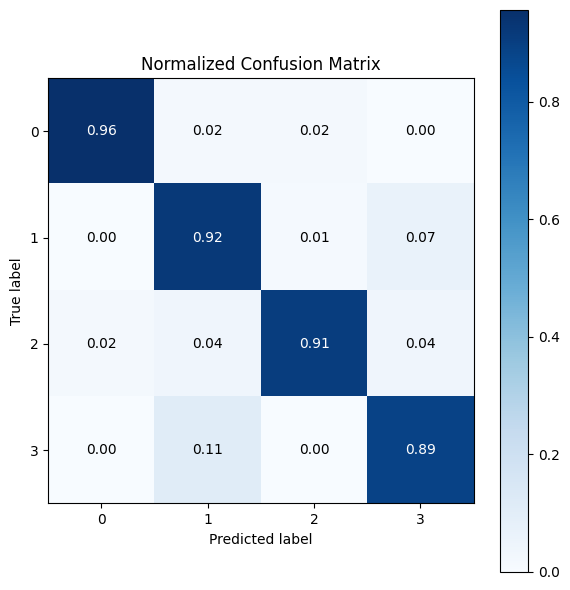

In [ ]:
metric_bm = kNN_Metric(
  model=model_bm,
  X_test=X_test.values,
  y_test=y_enc_test
)

metric_bs = kNN_Metric(
  model=model_bs,
  X_test=X_test.values,
  y_test=y_enc_test
)

results_bm = metric_bm.evaluate()
results_bs = metric_bs.evaluate()

print("==== Max mean model")
print("Classification:", pd.DataFrame([results_bm["classification"]]) )
print("Probabilistic:", pd.DataFrame([results_bm["probabilistic"]]) )
print("ECE:", results_bm["ece"])
print(results_bm["classwise"]["classification_report"])
metric_bm.plot_reliability_diagram(n_bins=10)
metric_bm.plot_confusion_matrix(normalize=True, cmap="Blues")

print("==== Min variance model")
print("Classification:", pd.DataFrame([results_bs["classification"]]) )
print("Probabilistic:", pd.DataFrame([results_bs["probabilistic"]]) )
print("ECE:", results_bs["ece"])
print(results_bs["classwise"]["classification_report"])
metric_bs.plot_reliability_diagram(n_bins=10)
metric_bs.plot_confusion_matrix(normalize=True, cmap="Blues")
